In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETR     1259 non-null   float64
 1   AMD     1259 non-null   float64
 2   EPAM    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   MGIC    1259 non-null   float64
 7   RDWR    1259 non-null   float64
 8   IDXX    1259 non-null   float64
 9   IQV     1259 non-null   float64
 10  BDSI    1259 non-null   float64
 11  ICLR    1259 non-null   float64
 12  MEDP    1259 non-null   float64
 13  MODV    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TROW    1259 non-null   float64
 16  CG      1259 non-null   float64
 17  CSWC    1259 non-null   float64
 18  TBBK    1259 non-null   float64
 19  CBRE    1259 non-null   float64
 20  SBAC    1259 non-null   float64
 21  ^FVX    1259 non-nu

## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.1,0.011419,0.024563,0.026617,0.015908,0.014737,
               0.005739,0.001016,0.034424,0.001042,0.006973,
               0.006295,0.008102,0.009335,0.033829,0.02456,
               0.031718,0.021091,0.022631,0.03152,0.06848,0.5]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,5.928613,0.130519,1.563681,2.800371,0.092684,0.313161,0.033693,0.014915,4.048262,0.080161,...,1.053773,1.621866,0.389678,0.207695,0.182406,0.995086,7.128927,0.9720,28.689120,NaN
2017-01-04,5.954621,0.130519,1.580875,2.786933,0.091559,0.316109,0.033937,0.014996,3.991463,0.080526,...,1.092677,1.646032,0.400919,0.212780,0.171996,1.011162,7.139061,0.9735,28.787891,0.003443
2017-01-05,5.933490,0.128350,1.590454,2.820401,0.088465,0.311688,0.034181,0.014925,3.991807,0.080234,...,1.120078,1.633200,0.407163,0.212526,0.162491,1.002651,7.044486,0.9315,28.656957,-0.004548
2017-01-06,5.952996,0.129263,1.642528,2.817358,0.090152,0.313161,0.033937,0.014884,4.074425,0.081088,...,1.119740,1.617161,0.415906,0.209729,0.162264,0.983424,6.993145,0.9610,28.778993,0.004259
2017-01-09,5.778242,0.131204,1.641791,2.852093,0.088746,0.312424,0.033937,0.014732,4.097144,0.081266,...,1.094030,1.557496,0.417155,0.212526,0.160680,0.981218,6.957342,0.9405,28.526317,-0.008780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.982580,1.762637,17.120411,21.597832,0.547275,1.205781,0.121441,0.041473,22.542213,0.293907,...,9.061435,4.895299,1.780966,0.529173,0.574601,3.397541,26.252492,0.6260,128.548454,0.020542
2021-12-28,11.087619,1.748820,16.756879,21.420564,0.543506,1.208434,0.119513,0.041077,22.419664,0.292396,...,8.584785,4.897510,1.759397,0.527908,0.566907,3.395334,26.346311,0.6225,127.456123,-0.008497
2021-12-29,11.147076,1.692981,16.649785,21.346301,0.546647,1.214918,0.119740,0.042134,22.571473,0.294094,...,8.724499,4.851582,1.724508,0.525166,0.577317,3.422442,26.361377,0.6470,127.608002,0.001192


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,5.928613,0.130519,1.563681,2.800371,0.092684,0.313161,0.033693,0.014915,4.048262,0.080161,...,1.053773,1.621866,0.389678,0.207695,0.182406,0.995086,7.128927,0.9720,28.689120,NaN
2017-01-04,5.954621,0.130519,1.580875,2.786933,0.091559,0.316109,0.033937,0.014996,3.991463,0.080526,...,1.092677,1.646032,0.400919,0.212780,0.171996,1.011162,7.139061,0.9735,28.787891,0.003443
2017-01-05,5.933490,0.128350,1.590454,2.820401,0.088465,0.311688,0.034181,0.014925,3.991807,0.080234,...,1.120078,1.633200,0.407163,0.212526,0.162491,1.002651,7.044486,0.9315,28.656957,-0.004548
2017-01-06,5.952996,0.129263,1.642528,2.817358,0.090152,0.313161,0.033937,0.014884,4.074425,0.081088,...,1.119740,1.617161,0.415906,0.209729,0.162264,0.983424,6.993145,0.9610,28.778993,0.004259
2017-01-09,5.778242,0.131204,1.641791,2.852093,0.088746,0.312424,0.033937,0.014732,4.097144,0.081266,...,1.094030,1.557496,0.417155,0.212526,0.160680,0.981218,6.957342,0.9405,28.526317,-0.008780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.982580,1.762637,17.120411,21.597832,0.547275,1.205781,0.121441,0.041473,22.542213,0.293907,...,9.061435,4.895299,1.780966,0.529173,0.574601,3.397541,26.252492,0.6260,128.548454,0.020542
2021-12-28,11.087619,1.748820,16.756879,21.420564,0.543506,1.208434,0.119513,0.041077,22.419664,0.292396,...,8.584785,4.897510,1.759397,0.527908,0.566907,3.395334,26.346311,0.6225,127.456123,-0.008497
2021-12-29,11.147076,1.692981,16.649785,21.346301,0.546647,1.214918,0.119740,0.042134,22.571473,0.294094,...,8.724499,4.851582,1.724508,0.525166,0.577317,3.422442,26.361377,0.6470,127.608002,0.001192


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,5.928613,0.130519,1.563681,2.800371,0.092684,0.313161,0.033693,0.014915,4.048262,0.080161,...,1.053773,1.621866,0.389678,0.207695,0.182406,0.995086,7.128927,0.9720,28.689120,NaN
2017-01-04,5.954621,0.130519,1.580875,2.786933,0.091559,0.316109,0.033937,0.014996,3.991463,0.080526,...,1.092677,1.646032,0.400919,0.212780,0.171996,1.011162,7.139061,0.9735,28.787891,0.003443
2017-01-05,5.933490,0.128350,1.590454,2.820401,0.088465,0.311688,0.034181,0.014925,3.991807,0.080234,...,1.120078,1.633200,0.407163,0.212526,0.162491,1.002651,7.044486,0.9315,28.656957,-0.004548
2017-01-06,5.952996,0.129263,1.642528,2.817358,0.090152,0.313161,0.033937,0.014884,4.074425,0.081088,...,1.119740,1.617161,0.415906,0.209729,0.162264,0.983424,6.993145,0.9610,28.778993,0.004259
2017-01-07,5.952996,0.129263,1.642528,2.817358,0.090152,0.313161,0.033937,0.014884,4.074425,0.081088,...,1.119740,1.617161,0.415906,0.209729,0.162264,0.983424,6.993145,0.9610,28.778993,0.004259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.982580,1.762637,17.120411,21.597832,0.547275,1.205781,0.121441,0.041473,22.542213,0.293907,...,9.061435,4.895299,1.780966,0.529173,0.574601,3.397541,26.252492,0.6260,128.548454,0.020542
2021-12-28,11.087619,1.748820,16.756879,21.420564,0.543506,1.208434,0.119513,0.041077,22.419664,0.292396,...,8.584785,4.897510,1.759397,0.527908,0.566907,3.395334,26.346311,0.6225,127.456123,-0.008497
2021-12-29,11.147076,1.692981,16.649785,21.346301,0.546647,1.214918,0.119740,0.042134,22.571473,0.294094,...,8.724499,4.851582,1.724508,0.525166,0.577317,3.422442,26.361377,0.6470,127.608002,0.001192


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,28.689120
2017-01-04,28.787891
2017-01-05,28.656957
2017-01-06,28.778993
2017-01-07,28.778993
...,...
2021-12-27,128.548454
2021-12-28,127.456123
2021-12-29,127.608002


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


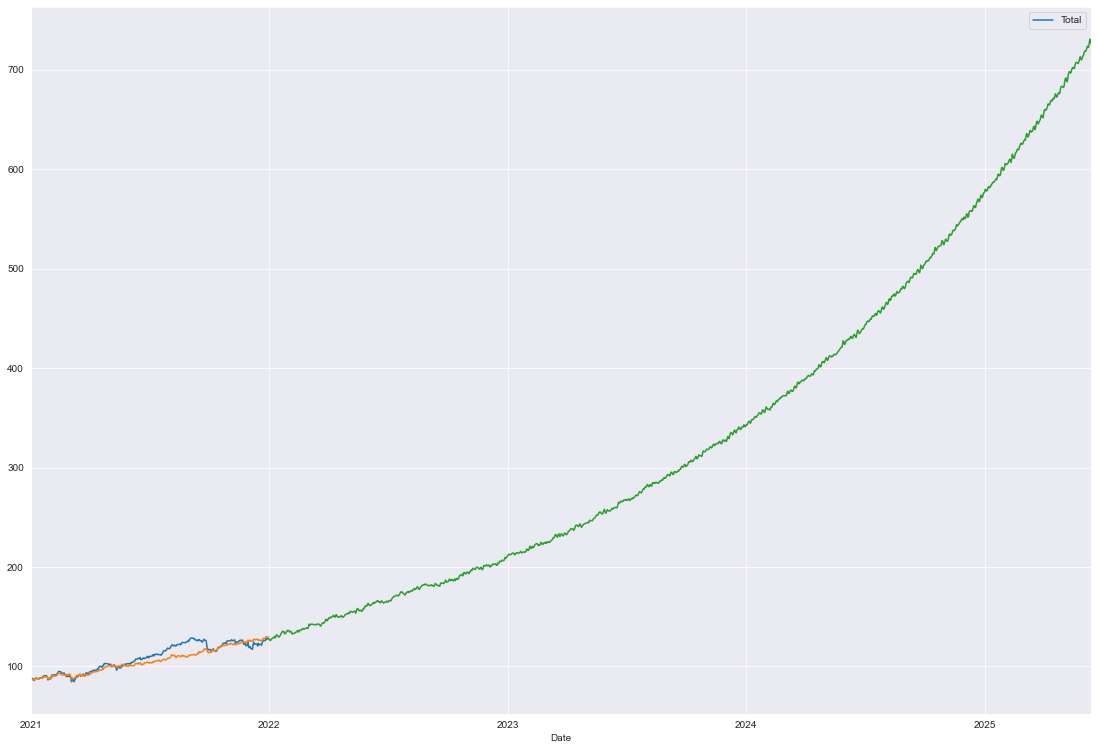

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2021-12-31    127.838651
2022-01-01    126.980589
2022-01-02    126.193059
2022-01-03    126.145557
2022-01-04    127.332043
                 ...    
2025-06-09    722.659839
2025-06-10    727.659373
2025-06-11    730.644834
2025-06-12    727.615601
2025-06-13    725.804287
Freq: D, Length: 1261, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2021-12-31,127.838651
2022-01-01,126.980589
2022-01-02,126.193059
2022-01-03,126.145557
2022-01-04,127.332043
...,...
2025-06-09,722.659839
2025-06-10,727.659373
2025-06-11,730.644834
2025-06-12,727.615601


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.006712
2022-01-02,-0.012872
2022-01-03,-0.013244
2022-01-04,-0.003963
...,...
2025-06-09,4.652906
2025-06-10,4.692014
2025-06-11,4.715367
2025-06-12,4.691671


In [26]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  41.524448
